In [1]:
import sys, os
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd 
from datetime import datetime
import tensorflow as ts 
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_squared_error

# Section 1: Simple RNN

In this section, we will build a recurrent neural network and train it to forecast a single time series. We'll use a dataset provided by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) that measures hourly air quality in Chinese cities/city districts<sup>1</sup>.

1. Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220â€“10236

In [2]:
dF_Beijing = pd.read_csv("Beijing.csv")
dF_Beijing = dF_Beijing[dF_Beijing.year >= 2015]
dF_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [3]:
dF_Beijing.columns

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi',
       'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'],
      dtype='object')

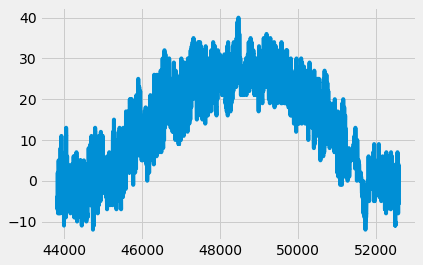

In [4]:
plt.plot(dF_Beijing['TEMP'])
plt.show()

Filling missing value some district with linear interpolate

In [5]:
for ColNames in dF_Beijing.columns:
    print(f'{ColNames} : <<{sum(dF_Beijing[ColNames].isna())}>> Missing Value')

No : <<0>> Missing Value
year : <<0>> Missing Value
month : <<0>> Missing Value
day : <<0>> Missing Value
hour : <<0>> Missing Value
season : <<0>> Missing Value
PM_Dongsi : <<164>> Missing Value
PM_Dongsihuan : <<3295>> Missing Value
PM_Nongzhanguan : <<287>> Missing Value
PM_US Post : <<129>> Missing Value
DEWP : <<5>> Missing Value
HUMI : <<339>> Missing Value
PRES : <<339>> Missing Value
TEMP : <<5>> Missing Value
cbwd : <<5>> Missing Value
Iws : <<5>> Missing Value
precipitation : <<459>> Missing Value
Iprec : <<459>> Missing Value


In [6]:
dF_Beijing['TEMP'] = dF_Beijing.TEMP.interpolate()
dF_Beijing['PM_Dongsi'] = dF_Beijing.PM_Dongsi.interpolate()
dF_Beijing.PM_Dongsi.head(10)

In [7]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

Parameters
funcfunction
Function to apply to each column or row.

axis{0 or ‘index’, 1 or ‘columns’}, default 0
Axis along which the function is applied:

0 or ‘index’: apply function to each column.

1 or ‘columns’: apply function to each row.

In [8]:
dF_Beijing['date'] = dF_Beijing.apply(make_date, axis = 1)
dF_Beijing.set_index(dF_Beijing.date, inplace = True)

In [9]:
Beijing_dF = dF_Beijing.drop(['No', 'year', 'month', 'day', 'hour'], axis = 1)

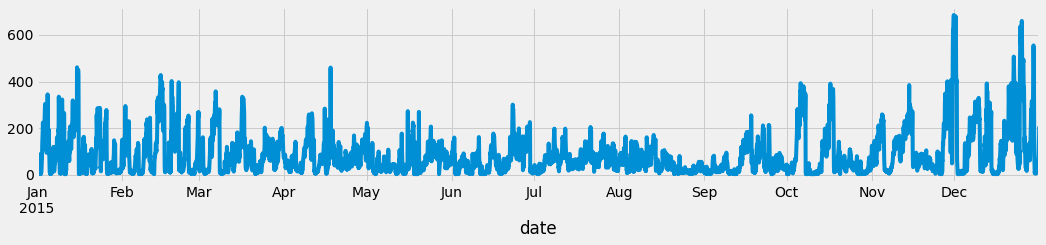

In [10]:
plt.figure(figsize=(16,3))
Beijing_dF.PM_Dongsi.plot(), 
plt.show()

In [11]:
def get_n_last_days(df, series_name, n_days):
    """

    Extract get last n_days of an hourly time series   

    """
    return df[series_name][-(24 * n_days):]

def plot_n_last_days(df, series_name, n_days):

    """
    Plot last n_days of an hourly time series
    """
    plt.figure(figsize=(15,3))
    plt.plot(get_n_last_days(df, series_name, n_days))
    plt.title(f'{series_name} Air Quality Time Series - {n_days}')
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha = .3)
    plt.show()

What do the last 6 weeks on data looks like

In [12]:
Beijing_dF.columns

Index(['season', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post',
       'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec',
       'date'],
      dtype='object')

In [13]:
get_n_last_days(Beijing_dF, "PM_Dongsi",42)

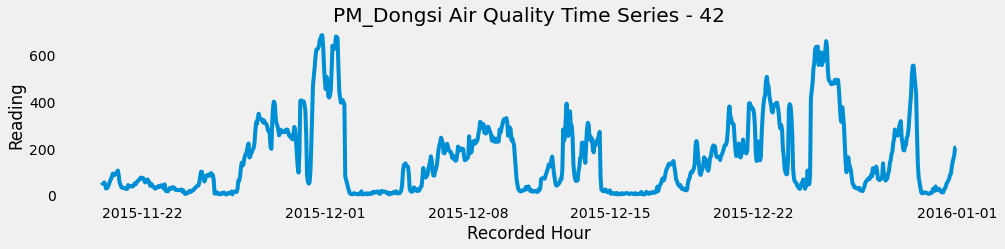

In [14]:
plot_n_last_days(Beijing_dF, "PM_Dongsi", 42)

In [15]:
dF_Beijing.shape

(8760, 19)

In [16]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y  

With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 56 days of the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next time step. We use the last day of data for visually testing the model.   

In [17]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_Y, test_y = \
    (get_train_test_data(Beijing_dF, 'PM_Dongsi', series_days, input_hours, test_hours))

In [18]:
train_X[0]

In [19]:
train_Y[0]

17.0

In [20]:
test_y[0]

50.0

In [21]:
train_y.shape

NameError: NameError: name 'train_y' is not defined

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each. 

In [120]:
print(f'Training Input Shape: {train_X.shape}')
print(f'Training Output Shape {train_Y.shape}')
print(f'Test Input Shape: {test_X_init.shape}')
print(f'Test Output Shape: {test_y.shape}')

Training Input Shape: (436, 12, 1)
Training Output Shape (436,)
Test Input Shape: (12,)
Test Output Shape: (12,)


And now we're ready to train! Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras. Take some time to understand what the keras syntax accomplishes at each step and how it relates to what we've learned about RNNs so far.  

In [32]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

Great, now let's use this function to fit a very simple baseline model.

In [33]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Not bad so far. But we need to work a bit harder to actually extract multi-step predictions from this model, as it was trained to predict only one future time step. For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model. We stop once we've generated all the time step predictions we need. 

This prediction method and a utility function for plotting its output against the ground truth are defined below. Take some time time to familiarize yourself with the prediction method.    

In [34]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

Ok, we've finally arrived at the time to see how our baseline model does. We can simply run the **predict_and_plot** function on the extracted test data as below, and inspect the resulting plot. 

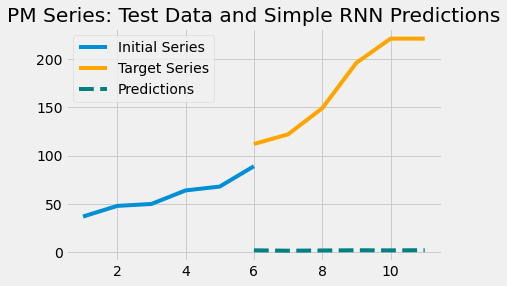

In [35]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

It looks like our model is badly underfit and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly. 

We can improve by making the model more expressive, **increasing cell_units**. We can also pass over the training data many more times, **increasing epochs**, giving the model more opportunity to learn the patterns in the data. We'll try that below, it takes a longer time now since our training is more extensive.

Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get
results that we're happy with.

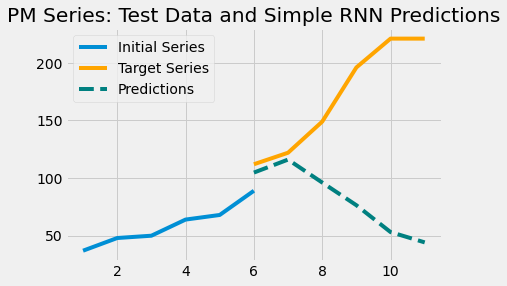

In [36]:
model = fit_SimpleRNN(train_X, train_y, cell_units = 30, epochs = 1200)
predict_and_plot(test_X_init, test_y, model, 
                 'PM Series: Test Data and Simple RNN Predictions')

We can definitely get better results than before. Note that the model has the capacity to forecast an upward trend based on the trough pattern that occured recently (the input sequence). 

Once we've created a model object, we can also get information about its structure and number of parameters by using the **summary** function. This is a useful way to measure the complexity of the model and get a feel for how long it may take to train. 

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


Note that even for this relatively simple model, we already have almost a thousand parameters to train. A larger number of cell units would increase the number of parameters - this is why the training process can become so time consuming. 

#### Exercise 1: Train a simple RNN to forecast the PM_Nongzhanguan time series

We can reuse all of the functions we've defined so far in order to train models on different time series. In this exercise, you'll train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.

**Step 1**: Interpolate the missing values in the "PM_Nongzhanguan" series and plot the last 42 days of the series to get a feel for the data. 

In [38]:
dF_Beijing.PM_Nongzhanguan = dF_Beijing.PM_Nongzhanguan.interpolate()
dF_Beijing.PM_Nongzhanguan.head(10)

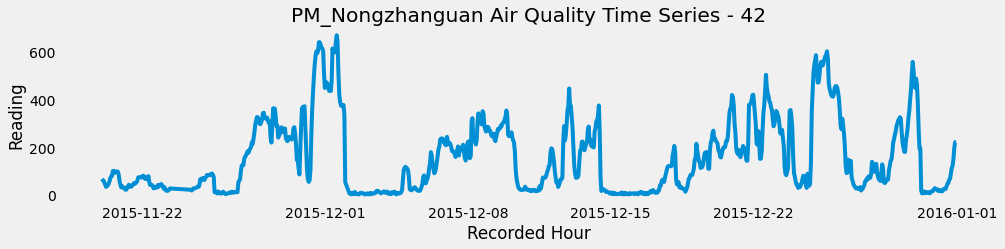

In [39]:
plot_n_last_days(dF_Beijing, "PM_Nongzhanguan", 42)

**Step 2**: Extract the train and test data for the "PM_Nongzhanguan" series using the function **get_train_test_data**. Use the following set of parameters:  

* **series_days** : 56
* **input_hours** : 6
* **test_hours** : 12

For reference, below is how we called the function earlier on. You can also pull up the function's documentation to review the various arguments. 

```
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))
```

In [40]:
series_days = 56
input_hours = 6
test_hours = 12

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(dF_Beijing, 'PM_Nongzhanguan', series_days,
                         input_hours, test_hours))

**Step 3**: Using the extracted train data to fit a simple RNN, and use the test data to generate and plot predictions.

* Start with a simple baseline -- few cell units and epochs. From here, try to make the model more expressive by increasing units and epochs until you're satisfied with the model's predictions. 

* Be careful not to set units and/or epochs *too* high. The model may become very slow to train and also start to badly overfit the training data with the extra complexity you've added.

For reference, here's example code that you can adapt:
```
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
```

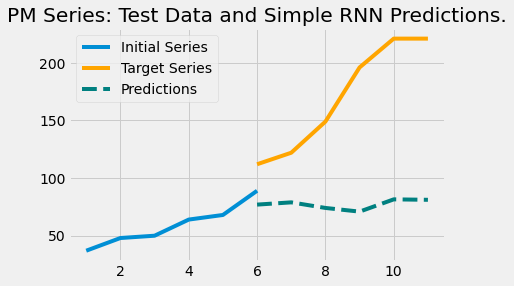

In [41]:
model = fit_SimpleRNN(train_X, train_y, cell_units = 30, epochs = 1200)

predict_and_plot(test_X_init, test_y, model, 
                 'PM Series: Test Data and Simple RNN Predictions.')

# Section 2: LSTM

In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far. Our first step will be to write a new function for fitting an LSTM with keras - notice that it's almost the same as our simple RNN function, with **LSTM** substitued for **SimpleRNN** (this is a nice display of how flexible keras is). 

Take some time to review the logic of the function while we go ahead and run the example cell below (it will take a while). 

In [43]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    # initialize model
    model = Sequential()
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape = (train_X.shape[1],1))) #,return_sequences= True))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(train_X, train_y, epochs = epochs, batch_size = 64, verbose = 1)

    return model



#### Example 2: Train a LSTM to forecast the PM_Nongzhanguan time series

With our new LSTM training function and all of our previously defined utility functions, adapting our code for LSTM forecasting will be fairly simple. We can extract the data as we did before, call the **fit_LSTM** function to build a model, and run the same *predict_and_plot* code.

Remember that one of the key benefits of LSTMs over simple RNNs is that they are better equipped to handle long input sequences and long-term dependencies. To see this evidence of this, we'll set *input_hours* to 12 and *test_hours* to 96 and see how our model predictions turn out with LSTM.  

Epoch 1/3000
6/6 [==============================] - 2s 7ms/step - loss: 44249.8125
Epoch 2/3000
6/6 [==============================] - 0s 6ms/step - loss: 44084.2656
Epoch 3/3000
6/6 [==============================] - 0s 7ms/step - loss: 43898.9688
Epoch 4/3000
6/6 [==============================] - 0s 6ms/step - loss: 43736.9492
Epoch 5/3000
6/6 [==============================] - 0s 8ms/step - loss: 43612.6719
Epoch 6/3000
6/6 [==============================] - 0s 6ms/step - loss: 43479.5547
Epoch 7/3000
6/6 [==============================] - 0s 6ms/step - loss: 43292.1016
Epoch 8/3000
6/6 [==============================] - 0s 7ms/step - loss: 43088.7930
Epoch 9/3000
6/6 [==============================] - 0s 6ms/step - loss: 42790.5781
Epoch 10/3000
6/6 [==============================] - 0s 9ms/step - loss: 42574.8516
Epoch 11/3000
6/6 [==============================] - 0s 6ms/step - loss: 42398.9648
Epoch 12/3000
6/6 [==============================] - 0s 6ms/step - loss: 42190.7969
E

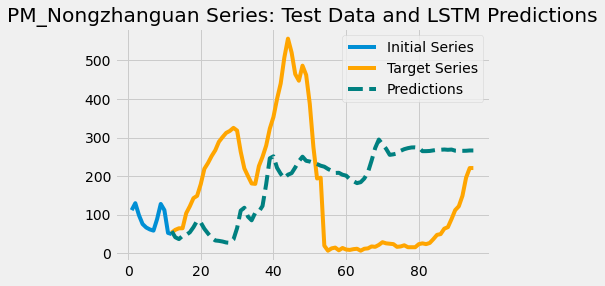

In [44]:
series_days = 50
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(dF_Beijing, 'PM_Nongzhanguan', series_days,
                        input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units = 70, epochs = 3000)
predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In our prediction plot we can start to see how LSTMs can be more expressive than simple RNNs - instead of just extrapolating a simple trend like our previous RNN models did, this LSTM model can effectively anticipate inflection points.

You should also notice that our model starts to struggle toward the end of the predicted sequence, becoming more conservative in its predictions. To improve the quality of forecasts over many time steps, we'd likely need to use more data and more sophisticated LSTM model structures that are beyond the scope of this lesson.

Take a look at the model summary and compare it with the summary for our simple RNN from example 1. You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20160     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
